In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json


In [2]:
#Load & Schema Fix
df = pd.read_csv("../dataset/telco_train.csv")
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
num_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

cat_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]


In [3]:
def blank_to_nan(X):
    return X.replace(r"^\s*$", np.nan, regex=True)
def normalize_strings(X):
    """
    Strip spaces and lowercase string columns only
    """
    X = X.copy()
    for col in X.columns:
        if X[col].dtype == "object":
            X[col] = X[col].str.strip().str.lower()
    return X
def coerce_numeric(X):
    X = X.copy()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")
    return X

In [4]:
numeric_transformer = Pipeline(steps=[
    ("blank_to_nan", FunctionTransformer(blank_to_nan, validate=False)),
    ("to_numeric", FunctionTransformer(coerce_numeric, validate=False)),
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("normalize", FunctionTransformer(normalize_strings, validate=False)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop="first",
        handle_unknown="ignore"
        # sparse_output=True (default)
    ))
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)


In [5]:
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor_rf),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight={0: 1, 1: 2},
        random_state=42,
        n_jobs=-1
    ))
])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [7]:
rf_clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [8]:
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]
# Train / Test accuracy
train_score = rf_clf.score(X_train, y_train)
test_score = rf_clf.score(X_test, y_test)

========== TRAINING PERFORMANCE ==========
Training Accuracy: 0.8376
Testing Accuracy : 0.8012

Accuracy      : 0.8012
Precision     : 0.6093
Recall        : 0.6990
F1 Score      : 0.6511
ROC-AUC Score : 0.8477
MCC Score     : 0.5154

Confusion Matrix:
[[694 134]
 [ 90 209]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       828
           1       0.61      0.70      0.65       299

    accuracy                           0.80      1127
   macro avg       0.75      0.77      0.76      1127
weighted avg       0.81      0.80      0.81      1127



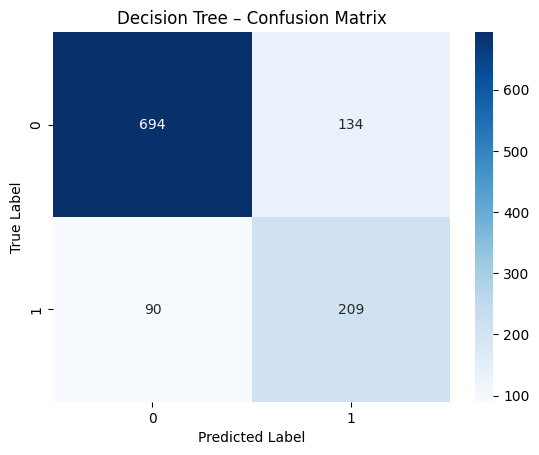

In [9]:
print("========== TRAINING PERFORMANCE ==========")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy : {test_score:.4f}")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nAccuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC-AUC Score : {roc_auc:.4f}")
print(f"MCC Score     : {mcc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [10]:

# CONFIGURAION
model_name = "RandomForest"   
phase = "train"               
save_path = "../models/results.json"

# METRICS
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred),
    "mcc": matthews_corrcoef(y_test, y_pred),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}

# LOAD EXISTING RESULTS
if os.path.exists(save_path) and os.path.getsize(save_path) > 0:
    with open(save_path, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

# UPDATE TRAIN
if model_name not in all_results:
    all_results[model_name] = {}

all_results[model_name][phase] = metrics

# SAVE BACK
with open(save_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"{model_name} ({phase}) results saved successfully")

RandomForest (train) results saved successfully


In [11]:
joblib.dump(rf_clf, "../models/random_forest.pkl")

['../models/random_forest.pkl']

========== TEST PERFORMANCE ==========
Accuracy      : 0.7779
Precision     : 0.5667
Recall        : 0.6925
F1 Score      : 0.6233
ROC-AUC Score : 0.8429
MCC Score     : 0.4728

Confusion Matrix:
[[837 198]
 [115 259]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.57      0.69      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.78      0.78      1409



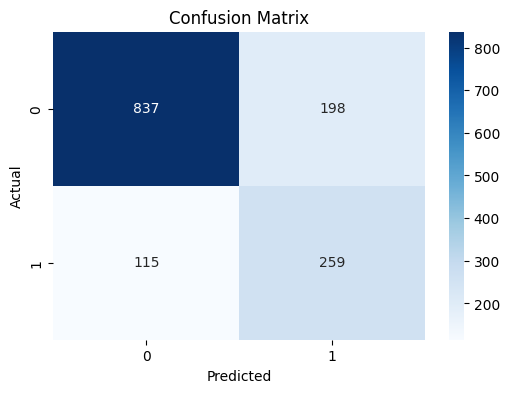

In [12]:
# 1. Load FULL pipeline (preprocessor + model)
loaded_model = joblib.load("../models/random_forest.pkl")

# 2. Load test data (NO manual preprocessing!)
test_df = pd.read_csv("../dataset/telco_test.csv")

X_final_test = test_df.drop(columns=["Churn"])
y_final_test = test_df["Churn"].map({"Yes": 1, "No": 0})

# 3. Predictions
y_pred = loaded_model.predict(X_final_test)
y_proba = loaded_model.predict_proba(X_final_test)[:, 1]

# 4. Evaluation
print("========== TEST PERFORMANCE ==========")

print(f"Accuracy      : {accuracy_score(y_final_test, y_pred):.4f}")
print(f"Precision     : {precision_score(y_final_test, y_pred):.4f}")
print(f"Recall        : {recall_score(y_final_test, y_pred):.4f}")
print(f"F1 Score      : {f1_score(y_final_test, y_pred):.4f}")
print(f"ROC-AUC Score : {roc_auc_score(y_final_test, y_proba):.4f}")
print(f"MCC Score     : {matthews_corrcoef(y_final_test, y_pred):.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_final_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_final_test, y_pred))

# 6. Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:

# CONFIGURAION
model_name = "RandomForest" 
phase = "evaluate"            
save_path = "../models/results.json"

# METRICS
metrics = {
    "accuracy": accuracy_score(y_final_test, y_pred),
    "precision": precision_score(y_final_test, y_pred),
    "recall": recall_score(y_final_test, y_pred),
    "f1": f1_score(y_final_test, y_pred),
    "roc_auc": roc_auc_score(y_final_test, y_proba),
    "mcc": matthews_corrcoef(y_final_test, y_pred),
    "confusion_matrix": confusion_matrix(y_final_test, y_pred).tolist()
}

# LOAD EXISTING RESULTS
if os.path.exists(save_path) and os.path.getsize(save_path) > 0:
    with open(save_path, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

# UPDATE EVALUATION
if model_name not in all_results:
    all_results[model_name] = {}

all_results[model_name][phase] = metrics

# SAVE BACK
with open(save_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"{model_name} ({phase}) results saved successfully")

RandomForest (evaluate) results saved successfully
